In [88]:
# import data from italy-house-prices/rome_raw_data.csv
import pandas as pd
data = pd.read_csv("italy-house-prices/rome-raw-data.csv", encoding="latin1")
# create a empty dataframe that will hold cleaned data
cleaned_data = pd.DataFrame()

In [89]:
# print all different values in the column 'contratto'
data['Efficienza energetica'].unique()

array(['G408.6 kWh/m² anno', 'F102.4 kWh/m² anno', 'E71.64 kWh/m² anno',
       ..., 'G215 kWh/m² anno', 'G11478 kWh/m² anno',
       'F167.25 kWh/m² anno'], shape=(1013,), dtype=object)

In [90]:
# functions to apply to each row of the data dataframe
# clean the "prezzo" column by removing the ###/mese and converting to float
def clean_price(row, warning = False):
    price = row['prezzo']
    if isinstance(price, str):
        # replace unknown characters with empty string
        price = price.replace('/mese', '')
        price = price.replace('\x80', '').replace(".", "").strip()
        try:
            return float(price)
        except ValueError:
            if warning is True:
                print(f"Warning: Could not convert price '{row['prezzo']}' to float.")
            return None
    return price

cleaned_data['prezzo'] = data.apply(clean_price, axis=1)

In [91]:
# spese condominio cleaning
def clean_spese_condominio(row, warning = False):
    spese = row['spese condominio']
    if isinstance(spese, str):
        # replace unknown characters with empty string
        spese = spese.replace('\x80', '').replace(".", "").strip()
        if spese.lower() in ['n.d.', 'nessuna', 'nessun', 'nessuno', 'non indicato', 'Nessuna spesa condominiale', 'nessuna spesa condominiale', 'nessun dato', '0', 'zero', 'null', 'nulla', 'nil', '-']:
            return 0.0
        try:
            return float(spese)
        except ValueError:
            if warning is True:
                print(f"Warning: Could not convert spese condominio '{row['spese condominio']}' to float.")
            return None
    return spese

cleaned_data['spese_condominio'] = data.apply(clean_spese_condominio, axis=1)

In [92]:

def clean_mq(row, warning = False):
    mq = row['m2']
    if isinstance(mq, str):
        mq = mq.replace('m²', '').strip()
        try:
            return float(mq)
        except ValueError:
            if warning is True:
                print(f"Warning: Could not convert m2 '{row['m2']}' to float.")
            return None
    return mq

cleaned_data['m2'] = data.apply(clean_mq, axis=1)


In [93]:
def clean_rooms(row, warning = False):
    stanze = row['stanze']
    if isinstance(stanze, str):
        stanze = stanze.strip()
        if stanze == '5+':
            return pd.Series({'rooms': 5, 'more_than_5_rooms': True})
        else:
            try:
                rooms = int(stanze)
                return pd.Series({'rooms': rooms, 'more_than_5_rooms': False})
            except ValueError:
                if warning is True:
                    print(f"Warning: Could not convert rooms '{row['stanze']}' to int.")
                return pd.Series({'rooms': None, 'more_than_5_rooms': None})
    return pd.Series({'rooms': stanze, 'more_than_5_rooms': False})

rooms_data = data.apply(clean_rooms, axis=1)
cleaned_data = pd.concat([cleaned_data, rooms_data], axis=1)


In [94]:
def clean_floor(row, warning = False):
    piano = row['piano']
    ascensore = False
    accesso_disabili = False
    piano_rialzato = False
    multi_floor = False
    floor_value = None
    totale_piani_edificio = row.get('totale piani edificio', None)
    ultimo_piano = False
    if isinstance(totale_piani_edificio, str):
        try:
            totale_piani_edificio = int(totale_piani_edificio.split()[0])
        except ValueError:
            print(f"Warning: Could not convert total floors '{row['totale piani edificio']}' to int.")
            totale_piani_edificio = None
    if isinstance(piano, str):
        piano = piano.lower().strip()
        if 'ascensore' in piano:
            ascensore = True
            piano = piano.replace('ascensore', '').strip()
        if 'accesso disabili' in piano:
            accesso_disabili = True
            piano = piano.replace('accesso disabili', '').strip()
        if 'seminterrato' in piano:
            floor_value = -1
        elif 'piano terra' in piano or 'terra' in piano:
            floor_value = 0
        elif 'piano rialzato' in piano:
            floor_value = 0
            piano_rialzato = True
        elif '°' in piano:
            try:
                parts = piano.replace(',', ' ').split()
                for part in parts:
                    if '°' in part:
                        floor_value = int(part.replace('°', ''))
                        break
            except ValueError:
                if warning is True:
                    print(f"Warning: Could not convert floor value '{row['piano']}' to int.")
                floor_value = None
            if totale_piani_edificio is not None and floor_value is not None:
                if floor_value >= totale_piani_edificio:
                    ultimo_piano = True
        else:
            if len(piano) > 2 and piano[1] != '°':
                multi_floor = True
    return pd.Series({
        'floor': floor_value,
        'ascensore': ascensore,
        'accesso_disabili': accesso_disabili,
        'piano_rialzato': piano_rialzato,
        'multi_floor': multi_floor,
        'totale_piani_edificio': totale_piani_edificio,
        'ultimo_piano': ultimo_piano
    })

floor_data = data.apply(clean_floor, axis=1)
cleaned_data = pd.concat([cleaned_data, floor_data], axis=1)


In [95]:
def clean_contratto(row, warning = False):
    contratto = row['contratto']
    affitto = False
    affitto_libero = False
    affitto_durata_minima = None
    affitto_durata_rinnovo = None
    affitto_concordato = False
    affitto_transitorio = False
    affitto_studenti = False
    affitto_riscatto = False
    immobile_a_reddito = False
    if isinstance(contratto, str):
        contratto = contratto.lower()
        if 'affitto' in contratto:
            affitto = True
        if 'libero' in contratto:
            affitto_libero = True
        if 'concordato' in contratto:
            affitto_concordato = True
        if 'transitorio' in contratto:
            affitto_transitorio = True
        if 'studenti' in contratto:
            affitto_studenti = True
        if 'riscatto' in contratto:
            affitto_riscatto = True
        if 'immobile a reddito' in contratto:
            immobile_a_reddito = True
        import re
        match = re.search(r'(\d+)\+(\d+)', contratto)
        if match:
            affitto_durata_minima = int(match.group(1))
            affitto_durata_rinnovo = int(match.group(2))
        else:
            affitto_durata_minima = 0
            affitto_durata_rinnovo = 0
    if warning is True and affitto is None or affitto_libero is None or affitto_durata_minima is None or affitto_durata_rinnovo is None or affitto_concordato is None or affitto_transitorio is None or affitto_studenti is None or affitto_riscatto is None or immobile_a_reddito is None:
        print(f"Warning: Could not parse contract type from '{row['contratto']}'.")
    return pd.Series({
        'affitto': affitto,
        'affitto_libero': affitto_libero,
        'affitto_durata_minima': affitto_durata_minima,
        'affitto_durata_rinnovo': affitto_durata_rinnovo,
        'affitto_concordato': affitto_concordato,
        'affitto_transitorio': affitto_transitorio,
        'affitto_studenti': affitto_studenti,
        'affitto_riscatto': affitto_riscatto,
        'immobile_a_reddito': immobile_a_reddito
    })

contract_data = data.apply(clean_contratto, axis=1)
cleaned_data = pd.concat([cleaned_data, contract_data], axis=1)


In [96]:
import re
def clean_locali(row, warning = False):
    locali = row['locali']
    totale_locali = 0
    camere_da_letto = 0
    altri_locali = 0
    tipo_cucina = ""
    campo_da_tennis = False
    if isinstance(locali, str):
        # Controlla per il campo da tennis
        if "campo da tennis" in locali:
            campo_da_tennis = True
        # Estrai il numero totale di locali
        match_totale = re.search(r'(\d+|\d+\+)', locali)
        if match_totale:
            totale_locali = int(match_totale.group(0).replace('+', ''))
        # Estrai camere da letto e altri locali
        match_locali = re.search(r'(\d+) camere da letto, (\d+) altri', locali)
        if match_locali:
            camere_da_letto = int(match_locali.group(1))
            altri_locali = int(match_locali.group(2))
        # Estrai il tipo di cucina
        match_cucina = re.search(r'cucina ([a-z\s]+)', locali)
        if match_cucina:
            tipo_cucina = match_cucina.group(1).strip()
    return pd.Series({
        'totale_locali': totale_locali,
        'camere_da_letto': camere_da_letto,
        'altri_locali': altri_locali,
        'tipo_cucina': tipo_cucina,
        'campo_da_tennis': campo_da_tennis
    })

locali_data = data.apply(clean_locali, axis=1)
cleaned_data = pd.concat([cleaned_data, locali_data], axis=1)
tipo_cucina_dummies = pd.get_dummies(cleaned_data['tipo_cucina'], prefix='cucina')
cleaned_data = pd.concat([cleaned_data, tipo_cucina_dummies], axis=1)

In [97]:
# cleaning function for 'bagni' column
# should add a 'bathrooms' column with integer values. 'bagni_per_locali' will be done later
def clean_bathrooms(row, warning = False):
    bagni = row['bagni']
    more_than_3_bathrooms = False
    if isinstance(bagni, str):
        bagni = bagni.strip()
        if bagni == '3+':
            more_than_3_bathrooms = True
            return pd.Series({'bathrooms': 3, 'more_than_3_bathrooms': more_than_3_bathrooms})
        else:
            try:
                bathrooms = int(bagni)
                return pd.Series({'bathrooms': bathrooms, 'more_than_3_bathrooms': more_than_3_bathrooms})
            except ValueError:
                if warning is True: 
                    print(f"Warning: Could not convert bathrooms '{row['bagni']}' to int.")
                return pd.Series({'bathrooms': None, 'more_than_3_bathrooms': more_than_3_bathrooms})
    return pd.Series({'bathrooms': bagni, 'more_than_3_bathrooms': more_than_3_bathrooms})

bathrooms_data = data.apply(clean_bathrooms, axis=1)
bathrooms_per_locali = bathrooms_data['bathrooms'] / cleaned_data['totale_locali']
bathrooms_data['bathrooms_per_locali'] = bathrooms_per_locali
cleaned_data = pd.concat([cleaned_data, bathrooms_data], axis=1)

In [98]:
import re

def parse_parking(row):
    posti_auto = row['Posti Auto']
    garage_box = 0
    esterno = 0
    parcheggio_comune = 0
    box_privato = 0

    if isinstance(posti_auto, str):
        # Extract counts for different parking types
        garage_box_matches = re.findall(r'(\d+) in garage/box', posti_auto)
        esterno_matches = re.findall(r'(\d+) all\'esterno', posti_auto)
        parcheggio_comune_matches = re.findall(r'(\d+) in parcheggio/garage comune', posti_auto)
        box_privato_matches = re.findall(r'(\d+) in box privato/box in garage', posti_auto)

        # Sum up the counts for each type
        garage_box = sum(map(int, garage_box_matches))
        esterno = sum(map(int, esterno_matches))
        parcheggio_comune = sum(map(int, parcheggio_comune_matches))
        box_privato = sum(map(int, box_privato_matches))

    return pd.Series({
        'garage_box': garage_box,
        'esterno': esterno,
        'parcheggio_comune': parcheggio_comune,
        'box_privato': box_privato
    })

temp_parking_data = data.apply(parse_parking, axis=1)


# Add the parsed parking data to the cleaned_data DataFrame
cleaned_data = pd.concat([cleaned_data, temp_parking_data], axis=1)

# One-hot encoding for parking presence
cleaned_data['has_garage_box'] = cleaned_data['garage_box'] > 0
cleaned_data['has_esterno'] = cleaned_data['esterno'] > 0
cleaned_data['has_parcheggio_comune'] = cleaned_data['parcheggio_comune'] > 0
cleaned_data['has_box_privato'] = cleaned_data['box_privato'] > 0

In [99]:
# parse the 'stato' column 
# values: ['Ottimo / Ristrutturato' 'Buono / Abitabile' 'Nuovo / In costruzione' nan 'Da ristrutturare']
# put into two columns: 'stato_condition' (Buono, Ottimo, Nuovo, Unknown), 'stato_renovation' (Ristrutturato, In costruzione,  Da ristrutturare, None)
# do one hot encoding
def parse_stato(row):
    stato = row['stato']
    stato_condition = 'Unknown'
    stato_renovation = None
    if isinstance(stato, str):
        parts = [part.strip() for part in stato.split('/')]
        if len(parts) == 2:
            stato_condition = parts[0]
            stato_renovation = parts[1]
        elif len(parts) == 1:
            stato_condition = parts[0]
    return pd.Series({
        'stato_condition': stato_condition,
        'stato_renovation': stato_renovation
    })

stato_data = data.apply(parse_stato, axis=1)
cleaned_data = pd.concat([cleaned_data, stato_data], axis=1)

# One-hot encode stato_condition and stato_renovation
stato_condition_dummies = pd.get_dummies(cleaned_data['stato_condition'], prefix='stato_condition')
stato_renovation_dummies = pd.get_dummies(cleaned_data['stato_renovation'], prefix='stato_renovation')
cleaned_data = pd.concat([cleaned_data, stato_condition_dummies, stato_renovation_dummies], axis=1)

In [100]:
import re

def parse_tipologia(row):
    tipologia = row['tipologia']
    # Initialize all boolean columns to False
    property_types = {
        'appartamento': False,
        'attico': False,
        'villa_unifamiliare': False,
        'villa_bifamiliare': False,
        'villa_plurifamiliare': False,
        'open_space': False,
        'mansarda': False,
        'loft': False,
        'palazzo_edificio': False,
        'casale': False,
        'terratetto_unifamiliare': False,
        'terratetto_plurifamiliare': False,
        'classe_signorile': False,
        'classe_media': False,
        'classe_economica': False,
        'immobile_di_lusso': False,
        'intera_proprieta': False,
        'parziale_proprieta': False,
        'diritto_di_superficie': False,
        'nuda_proprieta': False,
        'usufrutto': False,
        'multiproprieta': False
    }

    if isinstance(tipologia, str):
        # Normalize the string to lowercase
        tipologia = tipologia.lower()
        # Check for each property type in the string
        for key in property_types.keys():
            if key.replace('_', ' ') in tipologia:
                property_types[key] = True

    return pd.Series(property_types)

tipologia_data = data.apply(parse_tipologia, axis=1)
cleaned_data = pd.concat([cleaned_data, tipologia_data], axis=1)

In [101]:
# disponibilità column
# may be True or False, with True if contains libero and False otherwise
def clean_disponibilita(row, warning = False):
    disponibilita = row['disponibilità']
    if isinstance(disponibilita, str):
        disponibilita = disponibilita.lower().strip()
        if 'libero' in disponibilita:
            return True
        else:
            return False
    return disponibilita

cleaned_data['disponibilita'] = data.apply(clean_disponibilita, axis=1)


In [102]:
# parse 'anno di costruzione' column
def clean_anno_di_costruzione(row, warning = False):
    anno_di_costruzione = row['anno di costruzione']
    if isinstance(anno_di_costruzione, str):
        anno_di_costruzione = anno_di_costruzione.strip()
        try:
            return int(anno_di_costruzione)
        except ValueError:
            if warning is True:
                print(f"Warning: Could not convert anno_di_costruzione '{row['anno_di_costruzione']}' to int.")
            return None
    return anno_di_costruzione

anno_data = data.apply(clean_anno_di_costruzione, axis=1)
cleaned_data['anno_di_costruzione'] = anno_data

In [103]:
# parse riscaldamento column
def clean_riscaldamento(row, warning = False):
    riscaldamento = row['riscaldamento']
    autonomo = False
    centralizzato = False
    radiatori = False
    pavimento = False
    aria = False
    stufa = False
    gas = False
    metano = False
    gpl = False
    gasolio = False
    pompa_di_calore = False
    teleriscaldamento = False
    fotovoltaico = False
    solare = False
    elettrico = False
    pellet = False
    
    if isinstance(riscaldamento, str):
        riscaldamento = riscaldamento.lower()
        # Check for autonomo/centralizzato
        if 'autonomo' in riscaldamento:
            autonomo = True
        if 'centralizzato' in riscaldamento:
            centralizzato = True
        # Check for distribution system
        if 'radiatori' in riscaldamento:
            radiatori = True
        if 'pavimento' in riscaldamento:
            pavimento = True
        if 'aria' in riscaldamento:
            aria = True
        if 'stufa' in riscaldamento:
            stufa = True
        # Check for fuel/energy source
        if 'metano' in riscaldamento:
            metano = True
        if 'gas' in riscaldamento and 'gasolio' not in riscaldamento:
            gas = True
        if 'gpl' in riscaldamento:
            gpl = True
        if 'gasolio' in riscaldamento:
            gasolio = True
        if 'pompa di calore' in riscaldamento:
            pompa_di_calore = True
        if 'teleriscaldamento' in riscaldamento:
            teleriscaldamento = True
        if 'fotovoltaico' in riscaldamento:
            fotovoltaico = True
        if 'solare' in riscaldamento:
            solare = True
        if 'elettrica' in riscaldamento or 'elettrico' in riscaldamento:
            elettrico = True
        if 'pellet' in riscaldamento:
            pellet = True
    
    return pd.Series({
        'riscaldamento_autonomo': autonomo,
        'riscaldamento_centralizzato': centralizzato,
        'riscaldamento_radiatori': radiatori,
        'riscaldamento_pavimento': pavimento,
        'riscaldamento_aria': aria,
        'riscaldamento_stufa': stufa,
        'riscaldamento_gas': gas,
        'riscaldamento_metano': metano,
        'riscaldamento_gpl': gpl,
        'riscaldamento_gasolio': gasolio,
        'riscaldamento_pompa_calore': pompa_di_calore,
        'riscaldamento_teleriscaldamento': teleriscaldamento,
        'riscaldamento_fotovoltaico': fotovoltaico,
        'riscaldamento_solare': solare,
        'riscaldamento_elettrico': elettrico,
        'riscaldamento_pellet': pellet
    })

riscaldamento_data = data.apply(clean_riscaldamento, axis=1)
cleaned_data = pd.concat([cleaned_data, riscaldamento_data], axis=1) 

In [104]:
# parse climatizzatore column
def clean_climatizzatore(row, warning = False):
    climatizzatore = row['Climatizzatore']
    autonomo = False
    centralizzato = False
    predisposizione = False
    freddo = False
    caldo = False
    assente = False
    
    if isinstance(climatizzatore, str):
        climatizzatore = climatizzatore.lower()
        # Check for system type
        if 'autonomo' in climatizzatore:
            autonomo = True
        if 'centralizzato' in climatizzatore:
            centralizzato = True
        if 'predisposizione' in climatizzatore:
            predisposizione = True
        if 'assente' in climatizzatore:
            assente = True
        # Check for cooling/heating
        if 'freddo' in climatizzatore:
            freddo = True
        if 'caldo' in climatizzatore:
            caldo = True
    
    return pd.Series({
        'climatizzatore_autonomo': autonomo,
        'climatizzatore_centralizzato': centralizzato,
        'climatizzatore_predisposizione': predisposizione,
        'climatizzatore_freddo': freddo,
        'climatizzatore_caldo': caldo,
        'climatizzatore_assente': assente
    })

climatizzatore_data = data.apply(clean_climatizzatore, axis=1)
cleaned_data = pd.concat([cleaned_data, climatizzatore_data], axis=1)

In [105]:
# parse efficienza energetica column
def clean_efficienza_energetica(row, warning = False):
    efficienza = row['Efficienza energetica']
    classe = None
    classe_numerica = None
    consumo_kwh = None
    
    # Map energy classes to numerical values (A=1, B=2, ..., G=7)
    classe_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    
    if isinstance(efficienza, str):
        efficienza = efficienza.strip()
        # Extract the class (letter at the beginning)
        if len(efficienza) > 0 and efficienza[0].isalpha():
            classe = efficienza[0].upper()
            classe_numerica = classe_mapping.get(classe, None)
        
        # Extract the numeric value (kWh/m² anno)
        import re
        match = re.search(r'(\d+(?:[.,]\d+)?)', efficienza)
        if match:
            try:
                consumo_str = match.group(1).replace(',', '.')
                consumo_kwh = float(consumo_str)
            except ValueError:
                if warning is True:
                    print(f"Warning: Could not convert efficienza energetica '{efficienza}' to float.")
                consumo_kwh = None
    
    return pd.Series({
        'efficienza_classe': classe,
        'efficienza_classe_numerica': classe_numerica,
        'efficienza_consumo_kwh': consumo_kwh
    })

efficienza_data = data.apply(clean_efficienza_energetica, axis=1)
cleaned_data = pd.concat([cleaned_data, efficienza_data], axis=1)

In [106]:
def parse_altre_caratteristiche(row):
    caratteristiche_str = row['altre caratteristiche']
    features = {
        'terrazza': False,
        'reception': False,
        'idromassaggio': False,
        'ascensore': False,
        'esposizione_sud': False,
        'impianto_tv': False,
        'portiere': False,
        'balconi': False,
        'taverna': False,
        'cucina_arredata': False,
        'videocitofono': False,
        'box_garage': False,
        'piscina': False,
        'cantina': False,
        'caminetto': False,
        'esposizione_doppia': False,
        'arredato': False,
        'giardino': False,
        'armadio_a_muro': False,
        'piano_terra': False,
        'mansarda': False,
        'esposizione_interna': False,
        'cancello_elettrico': False,
        'esposizione_esterna': False,
        'infissi_qualità': False,
        'accesso_disabili': False,
        'esposizione_est': False,
        'campo_da_tennis': False,
        'impianto_di_allarme': False,
        'fibra_ottica': False,
        'porta_blindata': False
    }

    if isinstance(caratteristiche_str, str):
        caratteristiche_lower = [feature.strip().lower() for feature in caratteristiche_str.split(',')]
        caratteristiche_str_lower = ' '.join(caratteristiche_lower)
        
        # Check for consolidated features
        if any(x in caratteristiche_str_lower for x in ['balconi', '1 balcone', '2 balconi', '3 balconi', '4 balconi', '5 balconi', '6 balconi', '8 balconi', '18 balconi']):
            features['balconi'] = True
        if any(x in caratteristiche_str_lower for x in ['impianto tv singolo', 'impianto tv centralizzato', 'impianto tv con parabola']):
            features['impianto_tv'] = True
        if any(x in caratteristiche_str_lower for x in ['portiere intera giornata', 'portiere mezza giornata']):
            features['portiere'] = True
        if any(x in caratteristiche_str_lower for x in ['giardino privato', 'giardino comune', 'giardino privato e comune']):
            features['giardino'] = True
        if any(x in caratteristiche_str_lower for x in ['solo cucina arredata', 'parzialmente arredato']):
            features['cucina_arredata'] = True
        if any(x in caratteristiche_str_lower for x in ['box', 'garage', 'box/garage privato', '1 in box/garage privato']):
            features['box_garage'] = True
        if any(x in caratteristiche_str_lower for x in ['infissi', 'doppio vetro', 'triplo vetro']):
            features['infissi_qualità'] = True
        if 'porta blindata' in caratteristiche_str_lower:
            features['porta_blindata'] = True
        if 'terrazza' in caratteristiche_str_lower:
            features['terrazza'] = True
        if 'reception' in caratteristiche_str_lower:
            features['reception'] = True
        if 'idromassaggio' in caratteristiche_str_lower:
            features['idromassaggio'] = True
        if 'ascensore' in caratteristiche_str_lower or 'con ascensore' in caratteristiche_str_lower:
            features['ascensore'] = True
        if 'esposizione sud' in caratteristiche_str_lower:
            features['esposizione_sud'] = True
        if 'taverna' in caratteristiche_str_lower:
            features['taverna'] = True
        if 'videocitofono' in caratteristiche_str_lower:
            features['videocitofono'] = True
        if 'piscina' in caratteristiche_str_lower:
            features['piscina'] = True
        if 'cantina' in caratteristiche_str_lower:
            features['cantina'] = True
        if 'caminetto' in caratteristiche_str_lower:
            features['caminetto'] = True
        if 'esposizione doppia' in caratteristiche_str_lower:
            features['esposizione_doppia'] = True
        if 'arredato' in caratteristiche_str_lower:
            features['arredato'] = True
        if 'armadio a muro' in caratteristiche_str_lower:
            features['armadio_a_muro'] = True
        if 'piano terra' in caratteristiche_str_lower:
            features['piano_terra'] = True
        if 'mansarda' in caratteristiche_str_lower:
            features['mansarda'] = True
        if 'esposizione interna' in caratteristiche_str_lower:
            features['esposizione_interna'] = True
        if 'cancello elettrico' in caratteristiche_str_lower:
            features['cancello_elettrico'] = True
        if 'esposizione esterna' in caratteristiche_str_lower:
            features['esposizione_esterna'] = True
        if 'accesso disabili' in caratteristiche_str_lower or 'con accesso disabili' in caratteristiche_str_lower:
            features['accesso_disabili'] = True
        if 'esposizione est' in caratteristiche_str_lower:
            features['esposizione_est'] = True
        if 'campo da tennis' in caratteristiche_str_lower:
            features['campo_da_tennis'] = True
        if 'impianto di allarme' in caratteristiche_str_lower:
            features['impianto_di_allarme'] = True
        if 'fibra ottica' in caratteristiche_str_lower:
            features['fibra_ottica'] = True

    return pd.Series(features)

# Apply the consolidated parse_altre_caratteristiche function
altre_caratteristiche_data = data.apply(parse_altre_caratteristiche, axis=1)
cleaned_data = pd.concat([cleaned_data, altre_caratteristiche_data], axis=1)
cleaned_data

,prezzo,spese_condominio,m2,rooms,more_than_5_rooms,floor,ascensore,accesso_disabili,piano_rialzato,multi_floor,...,esposizione_interna,cancello_elettrico,esposizione_esterna,infissi_qualità,accesso_disabili,esposizione_est,campo_da_tennis,impianto_di_allarme,fibra_ottica,porta_blindata
0,850.0,NaN,45.0,2.0,False,0.0,True,False,False,False,...,True,False,False,True,False,False,False,False,False,True
1,900.0,NaN,55.0,2.0,False,7.0,True,False,False,False,...,False,False,True,True,False,True,False,False,False,True
2,1900.0,NaN,80.0,2.0,False,2.0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,True
3,3000.0,NaN,100.0,4.0,False,2.0,False,True,False,False,...,False,False,True,True,False,True,False,False,True,True
4,2400.0,NaN,165.0,4.0,False,0.0,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13270,1200.0,NaN,90.0,3.0,False,1.0,True,True,False,False,...,False,True,True,True,False,True,False,False,True,True
13271,550.0,NaN,30.0,1.0,False,0.0,False,False,False,False,...,True,True,False,True,False,False,False,False,False,False
13272,1100.0,NaN,116.0,3.0,False,1.0,True,False,False,False,...,False,False,True,True,False,True,False,False,False,True
13273,1000.0,NaN,70.0,2.0,False,3.0,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [107]:
# add quartiere column from data and one-hot encode it
cleaned_data['quartiere'] = data['quartiere']
quartiere_dummies = pd.get_dummies(cleaned_data['quartiere'], prefix='quartiere')
cleaned_data = pd.concat([cleaned_data, quartiere_dummies], axis=1)

In [108]:
# add voices from descrizione column
# first get all unique words in the descrizione column
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=None, min_df=0.01, max_df=0.90)
descrizione_matrix = vectorizer.fit_transform(data['description'].fillna(''))
descrizione_df = pd.DataFrame(descrizione_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# order by columns alphabetically
descrizione_df = descrizione_df.reindex(sorted(descrizione_df.columns), axis=1)

# print common words (columns) in descrizione_df
common_words = descrizione_df.sum().sort_values(ascending=False)
print("Common words in 'descrizione' column:")
# put common words into csv
common_words.to_csv("common_words_descrizione.csv")

# print unique couples of words from 

def parse_description(row):
    description = row['description']
    features = {
        "metro": 0,
        "stazione": 0,
        "universita": 0,
        "ospedale": 0,
        "parco": 0,
        "doccia": 0,
        "vasca": 0,
        "luminoso": 0,
        "silenzioso": 0,
        "guardaroba": 0,
        "mercato": 0,
    }

    if isinstance(description, str):
        description = description.lower()
        if "metro" or "metropolitana" in description:
            features["metro"] = 1
        if "stazione" or "treno" in description:
            features["stazione"] = 1
        if "universita" or "università" in description:
            features["universita"] = 1
        if "ospedale" in description:
            features["ospedale"] = 1
        if "parco" in description:
            features["parco"] = 1
        if "doccia" in description:
            features["doccia"] = 1
        if "vasca" in description:
            features["vasca"] = 1
        if "luminoso" or "luminosa" in description:
            features["luminoso"] = 1
        if "silenzioso" or "silenziosa" in description:
            features["silenzioso"] = 1
        if "guardaroba" in description:
            features["guardaroba"] = 1
        if "mercato" or "supermercato" or "super market" or "supermarket" in description:
            features["mercato"] = 1

    return pd.Series(features)

description_data = data.apply(parse_description, axis=1)
cleaned_data = pd.concat([cleaned_data, description_data], axis=1)

Common words in 'descrizione' column:


In [109]:
# add cauzione column as float
def clean_cauzione(row, warning = False):
    cauzione = row['cauzione']
    if isinstance(cauzione, str):
        cauzione = cauzione.replace('\x80', '').replace(".", "").strip()
        try:
            return float(cauzione)
        except ValueError:
            if warning is True:
                print(f"Warning: Could not convert cauzione '{row['cauzione']}' to float.")
            return None
    return cauzione

cleaned_data['cauzione'] = data.apply(clean_cauzione, axis=1)

In [110]:
# number of rows in data before
print(f"Number of rows in data: {len(data)}")

# print columns where you have null values
print(cleaned_data.columns[cleaned_data.isnull().any()])

# show how many rows are left after cleaning
print(f"Number of rows after cleaning: {len(cleaned_data)}")

Number of rows in data: 13275
Index(['prezzo', 'spese_condominio', 'm2', 'rooms', 'more_than_5_rooms',
       'floor', 'totale_piani_edificio', 'bathrooms', 'bathrooms_per_locali',
       'stato_renovation', 'disponibilita', 'anno_di_costruzione',
       'efficienza_classe', 'efficienza_classe_numerica',
       'efficienza_consumo_kwh', 'quartiere', 'cauzione'],
      dtype='object')
Number of rows after cleaning: 13275


In [111]:
cleaned_data

,prezzo,spese_condominio,m2,rooms,more_than_5_rooms,floor,ascensore,accesso_disabili,piano_rialzato,multi_floor,...,universita,ospedale,parco,doccia,vasca,luminoso,silenzioso,guardaroba,mercato,cauzione
0,850.0,NaN,45.0,2.0,False,0.0,True,False,False,False,...,1,0,0,1,0,1,1,0,1,NaN
1,900.0,NaN,55.0,2.0,False,7.0,True,False,False,False,...,1,0,0,1,0,1,1,0,1,NaN
2,1900.0,NaN,80.0,2.0,False,2.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,NaN
3,3000.0,NaN,100.0,4.0,False,2.0,False,True,False,False,...,1,0,0,0,0,1,1,0,1,NaN
4,2400.0,NaN,165.0,4.0,False,0.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13270,1200.0,NaN,90.0,3.0,False,1.0,True,True,False,False,...,1,0,0,0,0,1,1,0,1,3600.0
13271,550.0,NaN,30.0,1.0,False,0.0,False,False,False,False,...,1,0,0,0,0,1,1,0,1,1100.0
13272,1100.0,NaN,116.0,3.0,False,1.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,2200.0
13273,1000.0,NaN,70.0,2.0,False,3.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,NaN


In [112]:
# remove outliers and duplicates
# outliers defined in percentiles 1 and 99 for prezzo, m2, prezzo/m2
prezzo_lower = cleaned_data['prezzo'].quantile(0.10)
prezzo_upper = cleaned_data['prezzo'].quantile(0.90)
m2_lower = cleaned_data['m2'].quantile(0.10)
m2_upper = cleaned_data['m2'].quantile(0.90)

# Filter out outliers
print(f"Initial rows: {len(cleaned_data)}")
cleaned_data = cleaned_data[(cleaned_data['prezzo'] >= prezzo_lower) & (cleaned_data['prezzo'] <= prezzo_upper)]
print(f"After prezzo filtering: {len(cleaned_data)}")

cleaned_data = cleaned_data[(cleaned_data['m2'] >= m2_lower) & (cleaned_data['m2'] <= m2_upper)]
print(f"After m2 filtering: {len(cleaned_data)}")

# Remove duplicates
cleaned_data = cleaned_data.drop_duplicates()
print(f"After removing duplicates: {len(cleaned_data)}")

# Reset index
cleaned_data = cleaned_data.reset_index(drop=True)
print(f"\nFinal cleaned dataset shape: {cleaned_data.shape}")
print(f"Final columns: {cleaned_data.columns.tolist()}")
cleaned_data.head()


Initial rows: 13275
After prezzo filtering: 10794
After m2 filtering: 9367
After removing duplicates: 8461

Final cleaned dataset shape: (8461, 404)
Final columns: ['prezzo', 'spese_condominio', 'm2', 'rooms', 'more_than_5_rooms', 'floor', 'ascensore', 'accesso_disabili', 'piano_rialzato', 'multi_floor', 'totale_piani_edificio', 'ultimo_piano', 'affitto', 'affitto_libero', 'affitto_durata_minima', 'affitto_durata_rinnovo', 'affitto_concordato', 'affitto_transitorio', 'affitto_studenti', 'affitto_riscatto', 'immobile_a_reddito', 'totale_locali', 'camere_da_letto', 'altri_locali', 'tipo_cucina', 'campo_da_tennis', 'cucina_', 'cucina_a vista', 'cucina_abitabile', 'cucina_angolo cottura', 'cucina_cucinotto', 'cucina_semi abitabile', 'bathrooms', 'more_than_3_bathrooms', 'bathrooms_per_locali', 'garage_box', 'esterno', 'parcheggio_comune', 'box_privato', 'has_garage_box', 'has_esterno', 'has_parcheggio_comune', 'has_box_privato', 'stato_condition', 'stato_renovation', 'stato_condition_Buono

,prezzo,spese_condominio,m2,rooms,more_than_5_rooms,floor,ascensore,accesso_disabili,piano_rialzato,multi_floor,...,universita,ospedale,parco,doccia,vasca,luminoso,silenzioso,guardaroba,mercato,cauzione
0,850.0,NaN,45.0,2.0,False,0.0,True,False,False,False,...,1,0,0,1,0,1,1,0,1,NaN
1,900.0,NaN,55.0,2.0,False,7.0,True,False,False,False,...,1,0,0,1,0,1,1,0,1,NaN
2,1900.0,NaN,80.0,2.0,False,2.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,NaN
3,1350.0,NaN,72.0,3.0,False,2.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,2700.0
4,1300.0,NaN,60.0,2.0,False,2.0,True,False,False,False,...,1,0,0,0,0,1,1,0,1,2600.0


In [113]:
# Remove non-encoded string columns that may cause issues
to_remove = ['tipo_cucina', 'stato_condition', 'stato_renovation', 'efficienza_classe', 'quartiere']
for col in to_remove:
    if col in cleaned_data.columns:
        cleaned_data = cleaned_data.drop(col, axis=1)


# Prepare data for regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Separate features and target
X = cleaned_data.drop('prezzo', axis=1)
y = cleaned_data['prezzo']

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Create a pipeline for Linear Regression with StandardScaler
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the Linear Regression pipeline
lr_pipeline.fit(X_train, y_train)

# Make predictions with Linear Regression on validation and test sets
y_pred_lr_val = lr_pipeline.predict(X_val)
y_pred_lr_test = lr_pipeline.predict(X_test)

# Evaluate Linear Regression on validation set
lr_mse_val = mean_squared_error(y_val, y_pred_lr_val)
lr_rmse_val = np.sqrt(lr_mse_val)
lr_mae_val = mean_absolute_error(y_val, y_pred_lr_val)
lr_r2_val = r2_score(y_val, y_pred_lr_val)

# Evaluate Linear Regression on test set
lr_mse_test = mean_squared_error(y_test, y_pred_lr_test)
lr_rmse_test = np.sqrt(lr_mse_test)
lr_mae_test = mean_absolute_error(y_test, y_pred_lr_test)
lr_r2_test = r2_score(y_test, y_pred_lr_test)

print("\n=== Linear Regression (with Scaling) Results ===")
print("Validation Set:")
print(f"  MSE: {lr_mse_val:.2f}, RMSE: {lr_rmse_val:.2f}, MAE: {lr_mae_val:.2f}, R²: {lr_r2_val:.4f}")
print("Test Set:")
print(f"  MSE: {lr_mse_test:.2f}, RMSE: {lr_rmse_test:.2f}, MAE: {lr_mae_test:.2f}, R²: {lr_r2_test:.4f}")

# Train a Random Forest model (no scaling needed)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest on validation and test sets
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate Random Forest on validation set
rf_mse_val = mean_squared_error(y_val, y_pred_rf_val)
rf_rmse_val = np.sqrt(rf_mse_val)
rf_mae_val = mean_absolute_error(y_val, y_pred_rf_val)
rf_r2_val = r2_score(y_val, y_pred_rf_val)

# Evaluate Random Forest on test set
rf_mse_test = mean_squared_error(y_test, y_pred_rf_test)
rf_rmse_test = np.sqrt(rf_mse_test)
rf_mae_test = mean_absolute_error(y_test, y_pred_rf_test)
rf_r2_test = r2_score(y_test, y_pred_rf_test)

print("\n=== Random Forest Results ===")
print("Validation Set:")
print(f"  MSE: {rf_mse_val:.2f}, RMSE: {rf_rmse_val:.2f}, MAE: {rf_mae_val:.2f}, R²: {rf_r2_val:.4f}")
print("Test Set:")
print(f"  MSE: {rf_mse_test:.2f}, RMSE: {rf_rmse_test:.2f}, MAE: {rf_mae_test:.2f}, R²: {rf_r2_test:.4f}")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features ===")
print(feature_importance.head(15))

Training set size: 6091
Validation set size: 1523
Test set size: 847

=== Linear Regression (with Scaling) Results ===
Validation Set:
  MSE: 53882.50, RMSE: 232.13, MAE: 157.97, R²: 0.7197
Test Set:
  MSE: 53325.90, RMSE: 230.92, MAE: 156.30, R²: 0.7087

=== Linear Regression (with Scaling) Results ===
Validation Set:
  MSE: 53882.50, RMSE: 232.13, MAE: 157.97, R²: 0.7197
Test Set:
  MSE: 53325.90, RMSE: 230.92, MAE: 156.30, R²: 0.7087

=== Random Forest Results ===
Validation Set:
  MSE: 45338.77, RMSE: 212.93, MAE: 125.65, R²: 0.7642
Test Set:
  MSE: 43677.97, RMSE: 208.99, MAE: 119.76, R²: 0.7614

=== Top 15 Most Important Features ===
                        feature  importance
397                    cauzione    0.320920
1                            m2    0.266782
72          anno_di_costruzione    0.077872
9         totale_piani_edificio    0.018090
95   efficienza_classe_numerica    0.014244
64            immobile_di_lusso    0.012686
4                         floor    0.011567


In [114]:
# Display predictions comparison from both models on validation and test sets
print("=== Validation Set - First 10 Predictions ===")
val_predictions_df = pd.DataFrame({
    'Actual Price': y_val.head(10).values,
    'LR Prediction': y_pred_lr_val[:10],
    'RF Prediction': y_pred_rf_val[:10]
})
val_predictions_df['LR Error'] = abs(val_predictions_df['Actual Price'] - val_predictions_df['LR Prediction'])
val_predictions_df['RF Error'] = abs(val_predictions_df['Actual Price'] - val_predictions_df['RF Prediction'])
print(val_predictions_df.to_string())
print(f"\nValidation - Avg LR Error: €{val_predictions_df['LR Error'].mean():.2f}")
print(f"Validation - Avg RF Error: €{val_predictions_df['RF Error'].mean():.2f}")

print("\n=== Test Set - First 10 Predictions ===")
test_predictions_df = pd.DataFrame({
    'Actual Price': y_test.head(10).values,
    'LR Prediction': y_pred_lr_test[:10],
    'RF Prediction': y_pred_rf_test[:10]
})
test_predictions_df['LR Error'] = abs(test_predictions_df['Actual Price'] - test_predictions_df['LR Prediction'])
test_predictions_df['RF Error'] = abs(test_predictions_df['Actual Price'] - test_predictions_df['RF Prediction'])
print(test_predictions_df.to_string())
print(f"\nTest - Avg LR Error: €{test_predictions_df['LR Error'].mean():.2f}")
print(f"Test - Avg RF Error: €{test_predictions_df['RF Error'].mean():.2f}")

=== Validation Set - First 10 Predictions ===
   Actual Price  LR Prediction  RF Prediction    LR Error    RF Error
0         650.0     533.086767     651.850000  116.913233    1.850000
1        1000.0    1206.912456    1298.100000  206.912456  298.100000
2         900.0    1011.612553    1138.800000  111.612553  238.800000
3         800.0     694.065183     818.300000  105.934817   18.300000
4        1900.0    1439.532846    1101.400000  460.467154  798.600000
5         700.0     701.311545     741.900000    1.311545   41.900000
6        1500.0    1354.790785    1649.100000  145.209215  149.100000
7        1200.0    1000.964642    1168.700000  199.035358   31.300000
8         900.0    1100.039912     946.590000  200.039912   46.590000
9        1100.0     932.623985     996.533333  167.376015  103.466667

Validation - Avg LR Error: €171.48
Validation - Avg RF Error: €172.80

=== Test Set - First 10 Predictions ===
   Actual Price  LR Prediction  RF Prediction    LR Error  RF Error
0   

=== Ridge Regression (L2 Regularization) with Pipeline ===
Optimal Alpha (λ): 196.3041

Validation Set:
  MSE: 49346.47, RMSE: 222.14, MAE: 153.08, R²: 0.7433
Test Set:
  MSE: 47376.31, RMSE: 217.66, MAE: 150.65, R²: 0.7412

=== Top 15 Most Important Features (Ridge - Absolute Coefficient Values) ===
                         feature  coefficient  abs_coefficient
1                             m2   142.892847       142.892847
397                     cauzione    70.369960        70.369960
64             immobile_di_lusso    56.040115        56.040115
305         quartiere_Trastevere    50.599357        50.599357
241            quartiere_Parioli    39.975453        39.975453
247  quartiere_Piazza del Popolo    39.880974        39.880974
283             quartiere_Spagna    39.785042        39.785042
226              quartiere_Monti    37.719979        37.719979
244      quartiere_Piazza Navona    36.428227        36.428227
384    quartiere_Vittorio Veneto    36.026865        36.026865
307  

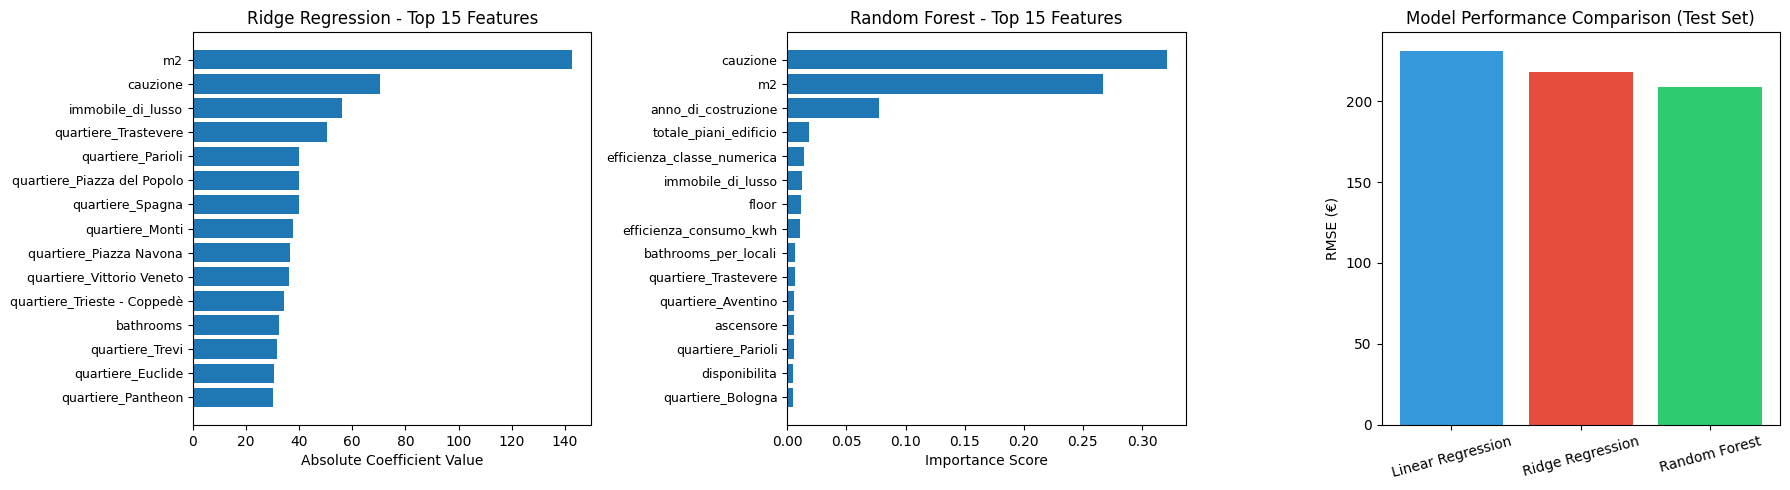

In [115]:
# Ridge Regression (L2 Regularization) with Pipeline (Imputer + Scaler)
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt

# Create Ridge pipeline with RidgeCV
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Find optimal alpha using cross-validation with the pipeline
alphas = np.logspace(-2, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')

# Wrap RidgeCV in a pipeline
ridge_pipeline_cv = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', ridge_cv)
])

# Train the pipeline
ridge_pipeline_cv.fit(X_train, y_train)

optimal_alpha = ridge_pipeline_cv.named_steps['regressor'].alpha_
print(f"=== Ridge Regression (L2 Regularization) with Pipeline ===")
print(f"Optimal Alpha (λ): {optimal_alpha:.4f}")

# Make predictions on validation and test sets
y_pred_ridge_val = ridge_pipeline_cv.predict(X_val)
y_pred_ridge_test = ridge_pipeline_cv.predict(X_test)

# Evaluate Ridge Regression on validation set
ridge_mse_val = mean_squared_error(y_val, y_pred_ridge_val)
ridge_rmse_val = np.sqrt(ridge_mse_val)
ridge_mae_val = mean_absolute_error(y_val, y_pred_ridge_val)
ridge_r2_val = r2_score(y_val, y_pred_ridge_val)

# Evaluate Ridge Regression on test set
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge_test)
ridge_rmse_test = np.sqrt(ridge_mse_test)
ridge_mae_test = mean_absolute_error(y_test, y_pred_ridge_test)
ridge_r2_test = r2_score(y_test, y_pred_ridge_test)

print("\nValidation Set:")
print(f"  MSE: {ridge_mse_val:.2f}, RMSE: {ridge_rmse_val:.2f}, MAE: {ridge_mae_val:.2f}, R²: {ridge_r2_val:.4f}")
print("Test Set:")
print(f"  MSE: {ridge_mse_test:.2f}, RMSE: {ridge_rmse_test:.2f}, MAE: {ridge_mae_test:.2f}, R²: {ridge_r2_test:.4f}")

# Feature importance from Ridge Regression (coefficients)
ridge_coefficients = ridge_pipeline_cv.named_steps['regressor'].coef_
ridge_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge_coefficients,
    'abs_coefficient': np.abs(ridge_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n=== Top 15 Most Important Features (Ridge - Absolute Coefficient Values) ===")
print(ridge_feature_importance.head(15)[['feature', 'coefficient', 'abs_coefficient']])

print("\n=== Comparison: All Models ===")
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest'],
    'Val RMSE': [lr_rmse_val, ridge_rmse_val, rf_rmse_val],
    'Test RMSE': [lr_rmse_test, ridge_rmse_test, rf_rmse_test],
    'Val R²': [lr_r2_val, ridge_r2_val, rf_r2_val],
    'Test R²': [lr_r2_test, ridge_r2_test, rf_r2_test]
})
print(comparison_df.to_string(index=False))

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ridge coefficients (top 15)
ridge_top15 = ridge_feature_importance.head(15)
axes[0].barh(range(len(ridge_top15)), ridge_top15['abs_coefficient'])
axes[0].set_yticks(range(len(ridge_top15)))
axes[0].set_yticklabels(ridge_top15['feature'], fontsize=9)
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_title('Ridge Regression - Top 15 Features')
axes[0].invert_yaxis()

# Random Forest feature importance (top 15)
feature_importance_top15 = feature_importance.head(15)
axes[1].barh(range(len(feature_importance_top15)), feature_importance_top15['importance'])
axes[1].set_yticks(range(len(feature_importance_top15)))
axes[1].set_yticklabels(feature_importance_top15['feature'], fontsize=9)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Random Forest - Top 15 Features')
axes[1].invert_yaxis()

# Model performance comparison
models = comparison_df['Model']
test_rmse_values = comparison_df['Test RMSE']
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[2].bar(models, test_rmse_values, color=colors)
axes[2].set_ylabel('RMSE (€)')
axes[2].set_title('Model Performance Comparison (Test Set)')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


In [116]:
# Print top features from both models
print("\n=== Feature Importance Summary ===")
print("\nRidge Regression - Top 10 Features (by absolute coefficient):")
for idx, row in ridge_feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

print("\nRidge Regression - all features with non-zero coefficients:")
print("# Feature with non-zero coefficients: ", sum(ridge_feature_importance['coefficient'] != 0))
for idx, row in ridge_feature_importance[ridge_feature_importance['coefficient'] != 0].iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")


=== Feature Importance Summary ===

Ridge Regression - Top 10 Features (by absolute coefficient):
  m2: 142.8928
  cauzione: 70.3700
  immobile_di_lusso: 56.0401
  quartiere_Trastevere: 50.5994
  quartiere_Parioli: 39.9755
  quartiere_Piazza del Popolo: 39.8810
  quartiere_Spagna: 39.7850
  quartiere_Monti: 37.7200
  quartiere_Piazza Navona: 36.4282
  quartiere_Vittorio Veneto: 36.0269

Ridge Regression - all features with non-zero coefficients:
# Feature with non-zero coefficients:  355
  m2: 142.8928
  cauzione: 70.3700
  immobile_di_lusso: 56.0401
  quartiere_Trastevere: 50.5994
  quartiere_Parioli: 39.9755
  quartiere_Piazza del Popolo: 39.8810
  quartiere_Spagna: 39.7850
  quartiere_Monti: 37.7200
  quartiere_Piazza Navona: 36.4282
  quartiere_Vittorio Veneto: 36.0269
  quartiere_Trieste - Coppedè: 34.1263
  bathrooms: 32.3960
  quartiere_Trevi: 31.6464
  quartiere_Euclide: 30.6761
  quartiere_Pantheon: 30.2828
  quartiere_Barberini: 29.8876
  quartiere_Bologna: 29.7669
  quartie

In [117]:
# do some predictions using ridge model
sample_data = X_test.head(500)
ridge_predictions = ridge_pipeline_cv.predict(sample_data)
print("\n=== Sample Predictions and Actual Values using Ridge Regression ===")
for i, pred in enumerate(ridge_predictions):
    actual = y_test.iloc[i]
    print(f"Sample {i+1}: Predicted Price = €{pred:.2f}, Actual Price = €{actual:.2f}")
# avg error for all samples
errors = [abs(y_test.iloc[i] - ridge_predictions[i]) for i in range(len(ridge_predictions))]
avg_error = sum(errors) / len(errors)
print(f"\nAverage Absolute Error for Sample Predictions: €{avg_error:.2f}")


=== Sample Predictions and Actual Values using Ridge Regression ===
Sample 1: Predicted Price = €1258.48, Actual Price = €1550.00
Sample 2: Predicted Price = €662.34, Actual Price = €700.00
Sample 3: Predicted Price = €900.84, Actual Price = €900.00
Sample 4: Predicted Price = €990.08, Actual Price = €900.00
Sample 5: Predicted Price = €1043.33, Actual Price = €900.00
Sample 6: Predicted Price = €559.14, Actual Price = €600.00
Sample 7: Predicted Price = €891.40, Actual Price = €800.00
Sample 8: Predicted Price = €891.31, Actual Price = €800.00
Sample 9: Predicted Price = €571.30, Actual Price = €700.00
Sample 10: Predicted Price = €1267.06, Actual Price = €1000.00
Sample 11: Predicted Price = €580.13, Actual Price = €650.00
Sample 12: Predicted Price = €591.22, Actual Price = €650.00
Sample 13: Predicted Price = €1114.33, Actual Price = €980.00
Sample 14: Predicted Price = €912.17, Actual Price = €950.00
Sample 15: Predicted Price = €696.35, Actual Price = €700.00
Sample 16: Predicte

=== Stochastic Gradient Descent (SGD) Regression with Pipeline ===



/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Validation Set:
  MSE: 10160263564801302528.00, RMSE: 3187516833.65, MAE: 287508240.21, R²: -52850191925128.1641
Test Set:
  MSE: 23345309610802020352.00, RMSE: 4831698418.86, MAE: 571448970.65, R²: -127535130328699.9219

=== Top 10 Most Important Features (SGD - Absolute Coefficient Values) ===
                                  feature   coefficient  abs_coefficient
145                     quartiere_Bologna  7.613585e+09     7.613585e+09
129      quartiere_Africano - Villa Chigi  7.050822e+09     7.050822e+09
173                   quartiere_Cinecittà  6.511819e+09     6.511819e+09
216                     quartiere_Marconi  6.066072e+09     6.066072e+09
275                 quartiere_San Lorenzo  5.976995e+09     5.976995e+09
205  quartiere_Gregorio VII - Piccolomini  5.887834e+09     5.887834e+09
285       quartiere_Talenti - Monte Sacro  5.798147e+09     5.798147e+09
251                     quartiere_Pigneto  5.737018e+09     5.737018e+09
274                quartiere_San Giovanni  5.6

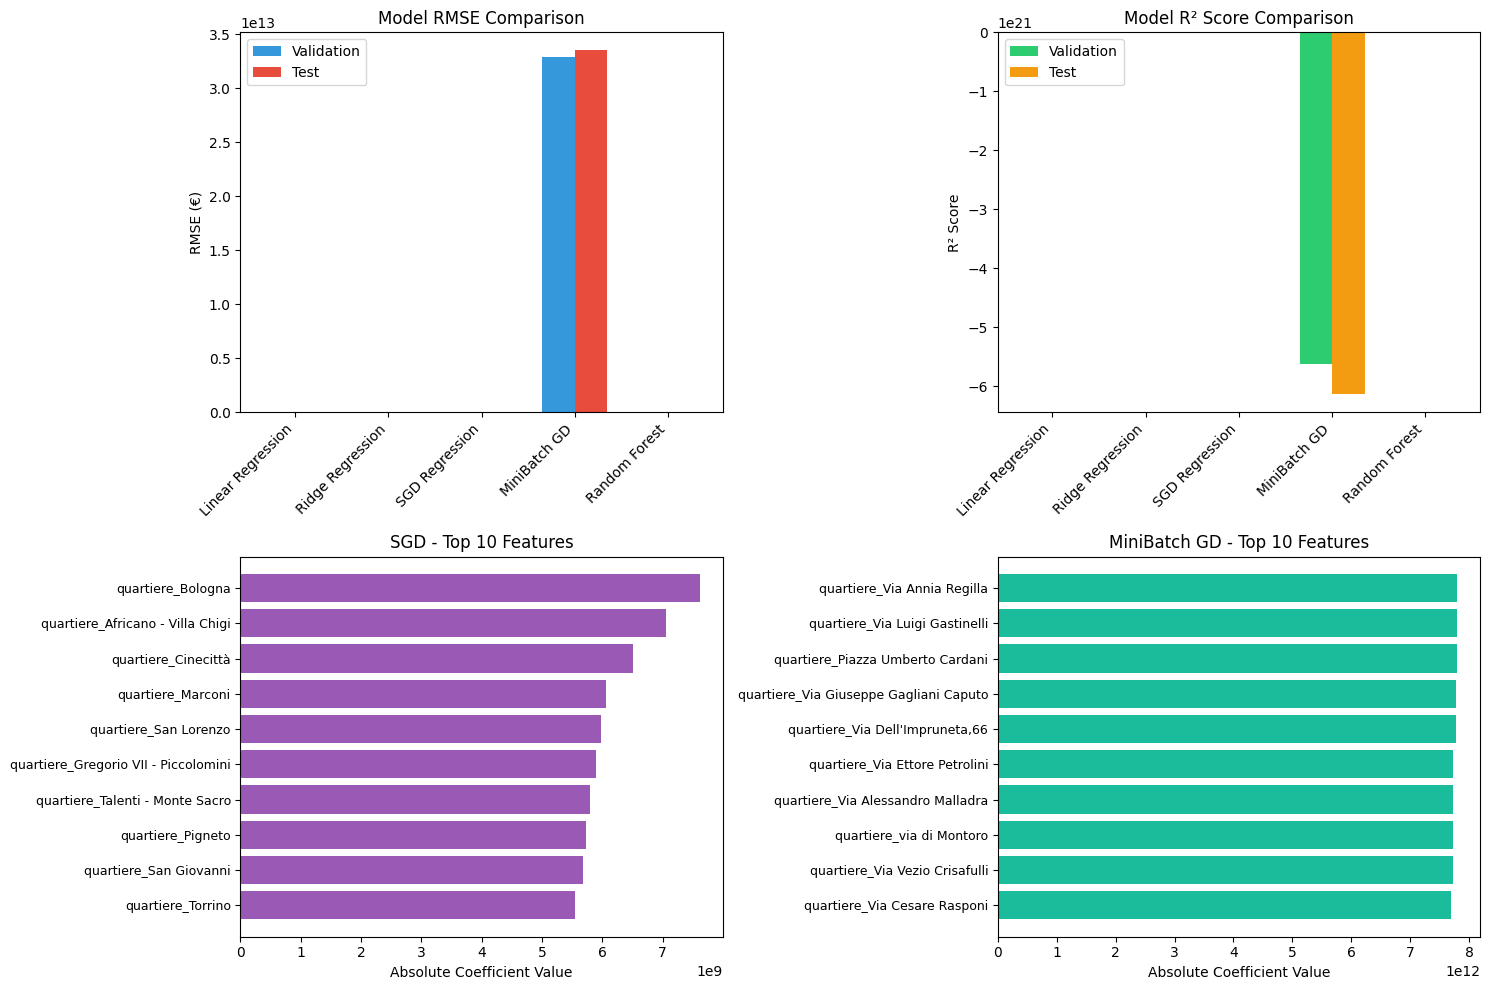


=== Feature Importance Summary ===

SGD - Top 5 Features:
  quartiere_Bologna: 7613585040.8376
  quartiere_Africano - Villa Chigi: 7050822370.8646
  quartiere_Cinecittà: 6511819069.1545
  quartiere_Marconi: 6066072094.2901
  quartiere_San Lorenzo: 5976994570.9333

MiniBatch GD - Top 5 Features:
  quartiere_Via Annia Regilla: -7795896439483.9590
  quartiere_Via Luigi Gastinelli: 7792361767335.7715
  quartiere_Piazza Umberto Cardani: 7791660295716.7939
  quartiere_Via Giuseppe Gagliani Caputo: -7786549421277.3848
  quartiere_Via Dell'Impruneta,66: -7777991169037.4570


In [118]:
# Stochastic Gradient Descent (SGD) and MiniBatch Gradient Descent with Pipelines
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt

print("=== Stochastic Gradient Descent (SGD) Regression with Pipeline ===\n")

# Create SGD pipeline with Imputer + Scaler
sgd_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor(loss='squared_error', learning_rate="adaptive", eta0=0.1, max_iter=10000, tol=1e-10, random_state=42))
])

# Train SGD pipeline
sgd_pipeline.fit(X_train, y_train)

# Make predictions on validation and test sets
y_pred_sgd_val = sgd_pipeline.predict(X_val)
y_pred_sgd_test = sgd_pipeline.predict(X_test)

# Evaluate SGD on validation set
sgd_mse_val = mean_squared_error(y_val, y_pred_sgd_val)
sgd_rmse_val = np.sqrt(sgd_mse_val)
sgd_mae_val = mean_absolute_error(y_val, y_pred_sgd_val)
sgd_r2_val = r2_score(y_val, y_pred_sgd_val)

# Evaluate SGD on test set
sgd_mse_test = mean_squared_error(y_test, y_pred_sgd_test)
sgd_rmse_test = np.sqrt(sgd_mse_test)
sgd_mae_test = mean_absolute_error(y_test, y_pred_sgd_test)
sgd_r2_test = r2_score(y_test, y_pred_sgd_test)

print("Validation Set:")
print(f"  MSE: {sgd_mse_val:.2f}, RMSE: {sgd_rmse_val:.2f}, MAE: {sgd_mae_val:.2f}, R²: {sgd_r2_val:.4f}")
print("Test Set:")
print(f"  MSE: {sgd_mse_test:.2f}, RMSE: {sgd_rmse_test:.2f}, MAE: {sgd_mae_test:.2f}, R²: {sgd_r2_test:.4f}")

# Feature coefficients from SGD
sgd_coefficients = sgd_pipeline.named_steps['regressor'].coef_
sgd_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': sgd_coefficients,
    'abs_coefficient': np.abs(sgd_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n=== Top 10 Most Important Features (SGD - Absolute Coefficient Values) ===")
print(sgd_feature_importance.head(10)[['feature', 'coefficient', 'abs_coefficient']])

print("\n" + "="*80)
print("=== MiniBatch Gradient Descent with Pipeline ===\n")

# Create MiniBatch GD pipeline (using SGDRegressor with batch_size parameter)
# Note: We'll use partial_fit for true online learning with mini-batches
minibatch_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# First, fit the imputer and scaler on training data
X_train_transformed = minibatch_pipeline.fit_transform(X_train)
X_val_transformed = minibatch_pipeline.transform(X_val)
X_test_transformed = minibatch_pipeline.transform(X_test)

# Create SGDRegressor for minibatch with smaller batch size
minibatch_regressor = SGDRegressor(
    loss='squared_error',
    max_iter=10000,
    tol=1e-5,
    random_state=42,
    learning_rate='adaptive',
    eta0=0.1
)

# Train with minibatches using partial_fit
batch_size = 32
n_batches = len(X_train_transformed) // batch_size

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    X_batch = X_train_transformed[start_idx:end_idx]
    y_batch = y_train.iloc[start_idx:end_idx]
    minibatch_regressor.partial_fit(X_batch, y_batch)

# Make predictions on validation and test sets
y_pred_minibatch_val = minibatch_regressor.predict(X_val_transformed)
y_pred_minibatch_test = minibatch_regressor.predict(X_test_transformed)

# Evaluate MiniBatch on validation set
minibatch_mse_val = mean_squared_error(y_val, y_pred_minibatch_val)
minibatch_rmse_val = np.sqrt(minibatch_mse_val)
minibatch_mae_val = mean_absolute_error(y_val, y_pred_minibatch_val)
minibatch_r2_val = r2_score(y_val, y_pred_minibatch_val)

# Evaluate MiniBatch on test set
minibatch_mse_test = mean_squared_error(y_test, y_pred_minibatch_test)
minibatch_rmse_test = np.sqrt(minibatch_mse_test)
minibatch_mae_test = mean_absolute_error(y_test, y_pred_minibatch_test)
minibatch_r2_test = r2_score(y_test, y_pred_minibatch_test)

print("Validation Set:")
print(f"  MSE: {minibatch_mse_val:.2f}, RMSE: {minibatch_rmse_val:.2f}, MAE: {minibatch_mae_val:.2f}, R²: {minibatch_r2_val:.4f}")
print("Test Set:")
print(f"  MSE: {minibatch_mse_test:.2f}, RMSE: {minibatch_rmse_test:.2f}, MAE: {minibatch_mae_test:.2f}, R²: {minibatch_r2_test:.4f}")

# Feature coefficients from MiniBatch
minibatch_coefficients = minibatch_regressor.coef_
minibatch_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': minibatch_coefficients,
    'abs_coefficient': np.abs(minibatch_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n=== Top 10 Most Important Features (MiniBatch - Absolute Coefficient Values) ===")
print(minibatch_feature_importance.head(10)[['feature', 'coefficient', 'abs_coefficient']])

print("\n" + "="*80)
print("=== Updated Model Comparison (All 5 Models) ===\n")

# Create comprehensive comparison dataframe
all_models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'SGD Regression', 'MiniBatch GD', 'Random Forest'],
    'Val RMSE': [lr_rmse_val, ridge_rmse_val, sgd_rmse_val, minibatch_rmse_val, rf_rmse_val],
    'Test RMSE': [lr_rmse_test, ridge_rmse_test, sgd_rmse_test, minibatch_rmse_test, rf_rmse_test],
    'Val R²': [lr_r2_val, ridge_r2_val, sgd_r2_val, minibatch_r2_val, rf_r2_val],
    'Test R²': [lr_r2_test, ridge_r2_test, sgd_r2_test, minibatch_r2_test, rf_r2_test]
})

print(all_models_comparison.to_string(index=False))

# Visualize all models comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE Comparison
models = all_models_comparison['Model']
val_rmse = all_models_comparison['Val RMSE']
test_rmse = all_models_comparison['Test RMSE']

x_pos = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x_pos - width/2, val_rmse, width, label='Validation', color='#3498db')
axes[0, 0].bar(x_pos + width/2, test_rmse, width, label='Test', color='#e74c3c')
axes[0, 0].set_ylabel('RMSE (€)')
axes[0, 0].set_title('Model RMSE Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()

# 2. R² Comparison
val_r2 = all_models_comparison['Val R²']
test_r2 = all_models_comparison['Test R²']

axes[0, 1].bar(x_pos - width/2, val_r2, width, label='Validation', color='#2ecc71')
axes[0, 1].bar(x_pos + width/2, test_r2, width, label='Test', color='#f39c12')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Model R² Score Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()

# 3. SGD top features
sgd_top10 = sgd_feature_importance.head(10)
axes[1, 0].barh(range(len(sgd_top10)), sgd_top10['abs_coefficient'], color='#9b59b6')
axes[1, 0].set_yticks(range(len(sgd_top10)))
axes[1, 0].set_yticklabels(sgd_top10['feature'], fontsize=9)
axes[1, 0].set_xlabel('Absolute Coefficient Value')
axes[1, 0].set_title('SGD - Top 10 Features')
axes[1, 0].invert_yaxis()

# 4. MiniBatch top features
minibatch_top10 = minibatch_feature_importance.head(10)
axes[1, 1].barh(range(len(minibatch_top10)), minibatch_top10['abs_coefficient'], color='#1abc9c')
axes[1, 1].set_yticks(range(len(minibatch_top10)))
axes[1, 1].set_yticklabels(minibatch_top10['feature'], fontsize=9)
axes[1, 1].set_xlabel('Absolute Coefficient Value')
axes[1, 1].set_title('MiniBatch GD - Top 10 Features')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n=== Feature Importance Summary ===")
print("\nSGD - Top 5 Features:")
for idx, row in sgd_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

print("\nMiniBatch GD - Top 5 Features:")
for idx, row in minibatch_feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

In [119]:
# print mean error for all models on test set
print("\n=== Mean Absolute Error Summary (Test Set) ===")
print(f"Linear Regression MAE: €{lr_mae_test:.2f}")
print(f"Ridge Regression MAE: €{ridge_mae_test:.2f}")
print(f"SGD Regression MAE: €{sgd_mae_test:.2f}")
print(f"MiniBatch GD MAE: €{minibatch_mae_test:.2f}")
print(f"Random Forest MAE: €{rf_mae_test:.2f}")


=== Mean Absolute Error Summary (Test Set) ===
Linear Regression MAE: €156.30
Ridge Regression MAE: €150.65
SGD Regression MAE: €571448970.65
MiniBatch GD MAE: €16169551638946.81
Random Forest MAE: €119.76
